In [1]:
import pickle
from datetime import datetime
from dateutil.tz import tzoffset

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
from scipy.sparse import hstack
from scipy.stats import kendalltau, spearmanr
from scipy.optimize import minimize, lbfgsb
from sklearn.preprocessing import LabelEncoder

In [2]:
with open("players.pkl", "rb") as fio:
    players = pickle.load(fio)

In [3]:
with open("results.pkl", "rb") as fio:
    results = pickle.load(fio)

In [4]:
with open("tournaments.pkl", "rb") as fio:
    tournaments = pickle.load(fio)

In [5]:
dateformat = "%Y-%m-%dT%H:%M:%S%z"

In [6]:
train_data =  []
test_data = []

for key, value in results.items():
    for team in value:
        for team_member in team["teamMembers"]:
            tournament_year = datetime.strptime(tournaments[key]["dateStart"], dateformat).year
            if team.get("mask", None) and tournament_year == 2019:
                train_data.append({
                    "tournament_id": key,
                    "tournament_name": tournaments.get(key).get("name"),
                    "team_id": team["team"]["id"],
                    "team_name": team["team"]["name"],
                    "questions_mask": team.get("mask", None),
                    "position": team.get("position", None),
                    "player_id": team_member["player"]["id"],
                    "player_name": team_member["player"]["surname"] + " " + \
                                   team_member["player"]["name"] + " " + \
                                   team_member["player"]["patronymic"]
                })
            elif team.get("mask", None) and tournament_year == 2020:
                test_data.append({
                    "tournament_id": key,
                    "tournament_name": tournaments.get(key).get("name"),
                    "team_id": team["team"]["id"],
                    "team_name": team["team"]["name"],
                    "questions_mask": team.get("mask", None),
                    "position": team.get("position", None),
                    "player_id": team_member["player"]["id"],
                    "player_name": team_member["player"]["surname"] + " " + \
                                   team_member["player"]["name"] + " " + \
                                   team_member["player"]["patronymic"]
                })

In [7]:
train_data = pd.DataFrame(train_data)
test_data = pd.DataFrame(test_data)

In [8]:
del results
del tournaments
del players

/home/imd/miniconda3/envs/made_advance/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


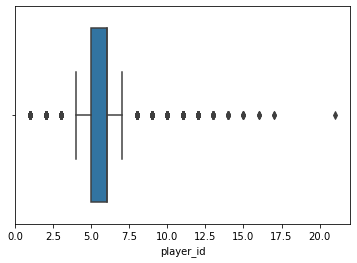

In [9]:
sns.boxplot(train_data.groupby(["team_id", "tournament_id"])["player_id"].nunique());

/home/imd/miniconda3/envs/made_advance/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


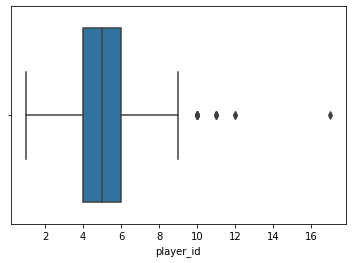

In [10]:
sns.boxplot(test_data.groupby(["team_id", "tournament_id"])["player_id"].nunique());

In [ ]:
train_data[train_data.groupby(["team_id", "tournament_id"])["player_id"].transform("nunique") > 6]["tournament_id"].nunique()

In [9]:
train_data.shape[0], test_data.shape[0]

(451783, 112841)

In [10]:
train_data["tournament_id"].nunique(), test_data["tournament_id"].nunique()

(675, 173)

In [11]:
train_data["mask_length"] = train_data["questions_mask"].apply(len)

In [12]:
tournament_mask_lengths = train_data.groupby("tournament_id")["mask_length"].nunique()

In [13]:
tournaments_to_remove = tournament_mask_lengths[tournament_mask_lengths > 1].index

In [14]:
train_data = train_data[~train_data["tournament_id"].isin(tournaments_to_remove)].copy()

In [15]:
train_data = train_data[train_data.groupby(["team_id", "tournament_id"])["player_id"].transform("nunique") <= 6].copy()

In [16]:
question_answer_data = {
    "question": [],
    "player": [],
    "initial_label": [],
    "team_id": [],
    "tournament_id": []
}
for tour_id, team_id, player_id, mask in zip(train_data["tournament_id"], train_data["team_id"], train_data["player_id"], train_data["questions_mask"]):
    for i, result in enumerate(mask):
        if result != "X" and result != "?":
            question_answer_data["tournament_id"].append(tour_id)
            question_answer_data["team_id"].append(team_id)
            question_answer_data["question"].append(f"{tour_id}_{i}")
            question_answer_data["player"].append(player_id)
            question_answer_data["initial_label"].append(int(result))

In [17]:
question_answer_data = pd.DataFrame(question_answer_data)

In [18]:
question_answer_data["player"] = question_answer_data["player"].astype(np.int32)
question_answer_data["team_id"] = question_answer_data["team_id"].astype(np.int32)
question_answer_data["tournament_id"] = question_answer_data["tournament_id"].astype(np.int32)
question_answer_data["question"] = question_answer_data["question"]
question_answer_data["initial_label"] = question_answer_data["initial_label"].astype(np.uint8)

In [19]:
encoder = LabelEncoder()

In [20]:
encoder.fit(question_answer_data["player"].astype(str).append(question_answer_data["question"]))

LabelEncoder()

In [21]:
question_answer_data["player"] = encoder.transform(question_answer_data["player"].astype(str))

In [22]:
question_answer_data["question"] = encoder.transform(question_answer_data["question"])

In [23]:
def sigmoid(x, theta):
    z = theta[-1] + theta[x["player"]] + theta[x["question"]]
    z[z > 0] = 1 / (1 + np.exp(-z[z > 0]))
    z[z <= 0] = np.exp(z[z <= 0]) / (1 + np.exp(z[z <= 0]))
    return z

In [24]:
def hypothesis(theta, x):
    return sigmoid(x, theta)

In [25]:
EPSILON = 1e-8

def cost_function(theta, x, y):
    m = x.shape[0]
    h = hypothesis(theta, x)
    cost = h
    cost[y == 1] = np.log(cost[y == 1] + EPSILON)
    cost[y == 0] = np.log(1 - cost[y == 0] + EPSILON)
    idx = (y > 0) & (y < 1)
    cost[idx] = y[idx] * np.log(cost[idx] + EPSILON) + (1 - y[idx]) * np.log(1 - h[idx] + EPSILON)
    return -cost.mean()

In [26]:
def gradient(theta, x, y):
    m = x.shape[0]
    h = hypothesis(theta, x)
    grad = np.zeros_like(theta)
    x = x.copy()
    x["step"] = h - y
    grad[-1] = x["step"].sum()
    ps = x.groupby("player")["step"].sum()
    qs = x.groupby("question")["step"].sum()
    grad[ps.index] = ps.values
    grad[qs.index] = qs.values
    return grad / m

In [27]:
def fit(x, y, theta, C=1):
    opt_weights = lbfgsb.fmin_l_bfgs_b(func=cost_function, x0=theta, fprime=gradient, args=(x, y.flatten()), maxiter=100)
    return opt_weights[0]

In [28]:
def predict(x, theta):
    return sigmoid(x, theta)

In [29]:
%%time
parameters = fit(question_answer_data[["player", "question"]], question_answer_data["initial_label"].values, theta = np.zeros(len(encoder.classes_) + 1))

CPU times: user 3min 39s, sys: 30.2 s, total: 4min 9s
Wall time: 4min 10s


In [30]:
def calc_metrics(data, encoder, parameters):
    player_weights = {}
    for i, c in enumerate(encoder.classes_):
        if "_" not in c:
            player_weights[int(c)] = parameters[i]
    data["player_weights"] = data["player_id"].map(player_weights)
    data["player_weights"].fillna(np.mean(list(player_weights.values())), inplace=True)
    data = data.groupby(["tournament_id", "team_id"]).agg({"player_weights": "sum", "position": "first"})
    data.sort_values(["tournament_id", "player_weights"], ascending=[True, False], inplace=True)
    data["predicted_position"] = data.groupby(["tournament_id"]).cumcount() + 1
    spear = data.groupby("tournament_id").apply(lambda x: spearmanr(x["position"], x["predicted_position"]).correlation).mean()
    kendl = data.groupby("tournament_id").apply(lambda x: kendalltau(x["position"], x["predicted_position"]).correlation).mean()
    print(f"spearman: {spear}")
    print(f"kendl: {kendl}")

In [31]:
calc_metrics(test_data, encoder, parameters)

spearman: 0.7605415445259895
kendl: 0.6006331041734562


In [32]:
def m_step(data, encoder, parameters):
    return fit(data[["player", "question"]], data["label"].values, parameters)

In [33]:
def e_step(data, params):
    data["label"] = predict(question_answer_data, params)
    data.loc[data["initial_label"] == 0, "label"] = 0
    idx = data["initial_label"] == 1
    sp = data.loc[idx].groupby(["tournament_id", "team_id", "question"])["label"].transform(lambda x: 1 - np.prod(1 - x.values))
    data.loc[idx, "label"] = data.loc[idx, "label"] / sp  
    return data

In [34]:
for i in range(0, 20):
    question_answer_data = e_step(question_answer_data, parameters)
    parameters = m_step(question_answer_data, encoder, parameters)
    print(f"Iter: {i}")
    calc_metrics(test_data, encoder, parameters)

Iter: 0
spearman: 0.7631364784426521
kendl: 0.6032029191139647
Iter: 1
spearman: 0.7631343509904771
kendl: 0.6032008950812024
Iter: 2
spearman: 0.7696377278823081
kendl: 0.6100757705339271
Iter: 3
spearman: 0.7696351467588806
kendl: 0.6100740048605889
Iter: 4
spearman: 0.7687539145556126
kendl: 0.6096175527406765
Iter: 5
spearman: 0.7687483497423888
kendl: 0.6096072245784743
Iter: 6
spearman: 0.772328309365498
kendl: 0.6129626470047876
Iter: 7
spearman: 0.7723282183385098
kendl: 0.6129623476821713
Iter: 8
spearman: 0.7723305759140073
kendl: 0.6131485921951056
Iter: 9
spearman: 0.7723305509297371
kendl: 0.6131485740533915
Iter: 10
spearman: 0.7726069105847433
kendl: 0.613601918557746
Iter: 11
spearman: 0.7740031856404525
kendl: 0.61498956507903
Iter: 12
spearman: 0.7740029749721916
kendl: 0.6149892587574666
Iter: 13
spearman: 0.7746393527553024
kendl: 0.6162332492220087
Iter: 14
spearman: 0.7746395684787672
kendl: 0.6162335681293916
Iter: 15
spearman: 0.7746395109335379
kendl: 0.6162334

KeyboardInterrupt: 

In [ ]:
for i in range(0, 20):
    question_answer_data = e_step(question_answer_data, parameters)
    parameters = m_step(question_answer_data, encoder, np.zeros_like(parameters))
    print(f"Iter: {i}")
    calc_metrics(test_data, encoder, parameters)

In [ ]:
question_answer_data.groupby(["tournament_id", "team_id", "question"])["label"].count().max()